# Earthquake epicenter estimation

_This notebook was created by Léonard Seydoux (seydoux@ipgp.fr) in 2022 for the course "Scientific Computing for Geophysical Problems" at the [institut de physique du globe de Paris](http://www.ipgp.fr)._ 

<img width=200px src="https://upload.wikimedia.org/wikipedia/fr/thumb/1/16/Institut_de_physique_du_globe_de_paris_logo.svg/1200px-Institut_de_physique_du_globe_de_paris_logo.svg.png" />


## Table of contents

1. [Introduction](#1.-Introduction)
    1. [Goals](#1.1.-Goals)
    2. [Requirements](#1.2.-Requirements)
2. [Synthetic dataset](#2.-Synthetic-dataset)
    1. [Synthetic data presentation](#2.1.-Synthetic-data-presentation)
    2. [Mean squared error source location](#2.2.-Mean-squared-error-source-location)
    3. [Residuals](#2.3.-Residuals)
    4. [Comparison with different misfit functions](#2.4.-Comparison-with-different-misfit-functions)
3. [Real dataset](#3.-Real-dataset)
    1. [Read data](#3.1.-Read-data)
    2. [Pick P and S arrival times](#3.2.-Pick-P-and-S-arrival-times)
    3. [Infer the earthquake epicenter](#3.3.-Infer-the-earthquake-epicenter)
    


## 1. Introduction

### 1.1. Goals


This Jupyter notebook shows how to locate a seismic event in space from the arrival times at several seismic station, as part of the _Scientific Computing for Geophysical Problems_ class. It is the first part of the earthquake localization notebooks. We will do this first part together during the class, and you will solve the second part at home, from real data. 

### 1.2. Requirements

This notebook relies on Python libraries listed below. If you are running this notebook on the virtual machine provided for the course, you should have all the required libraries installed. If you are running this notebook on your own machine, you will need to install the following libraries:

- [ObsPy](https://github.com/obspy/obspy/wiki), an open-source project that provides a Python framework for processing seismological data. It provides parsers for standard file formats, clients to access data centers, and signal processing routines that allow the manipulation of seismological time series.
- [NumPy](https://numpy.org), an open-source project aiming to enable numerical computing with Python.
- [SciPy](https://numpy.org), fundamental algorithms for scientific computing in Python.
- [Matplotlib](https://matplotlib.org), a comprehensive library for creating static, animated, and interactive visualizations in Python.

If unavailable on your machine, you can use the [Anaconda](https://www.anaconda.com) package manager to install these libraries. Please ensure you can run the following cell without any error before proceeding further.

In [5]:
from cartopy.crs import PlateCarree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import covseisnet
import seisbench.models as sbm

In [6]:
model = sbm.PhaseNet.from_pretrained("stead")

/Users/seydoux/anaconda3/envs/covseisnet/lib/python3.12/site-packages/seisbench/models/base.py:489: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(

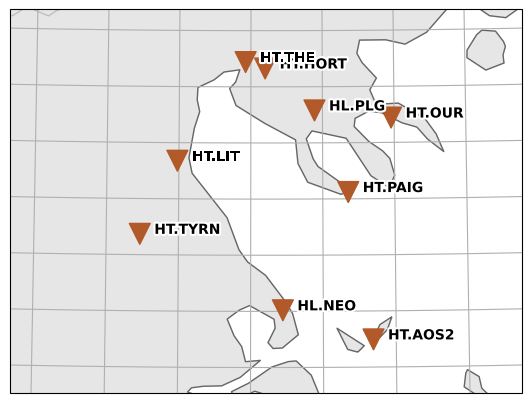

In [8]:
stream = covseisnet.read("./data/aegean_sea_example.mseed")
stream.merge(1, fill_value=0)
inventory = stream.download_inventory(datacenter="NOA")
stream.assign_coordinates(inventory)
fig = inventory.plot(projection="local", resolution="h");

In [11]:
# Perform P and S phase picking 
predictions = model.annotate(stream)

Text(0.0, 1.0, 'b')

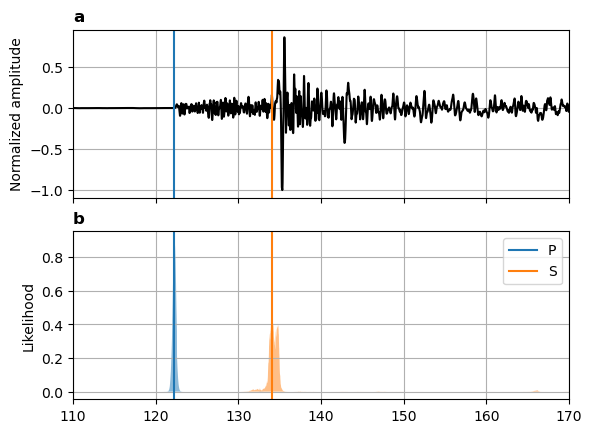

In [77]:
# Plot one prediction
station = "AOS2"
trace = stream.select(station=station, component="Z")[0]
picker_likelihoods = predictions.select(station=station)
offset = picker_likelihoods[0].stats.starttime - trace.stats.starttime

# Plot the trace
fig, ax = plt.subplots(nrows=2, sharex=True)

# Plot trace
ax[0].plot(trace.times(), trace.data / np.abs(trace.data).max(), "k")
ax[0].grid()
ax[0].set_ylabel("Normalized amplitude")
ax[0].set_title("a", loc="left", fontweight="bold")

# Plot P and S picks
for i, phase in enumerate(("P", "S")):

    # Extract likelihood
    likelihood = picker_likelihoods.select(channel="PhaseNet_" + phase)[0]
    time_max_likelihood = likelihood.times()[likelihood.data.argmax()] + offset

    # Plot likelihood
    ax[1].fill_between(likelihood.times() + offset, likelihood.data, alpha=0.5)
    ax[1].axvline(time_max_likelihood, color=f"C{i}", label=phase)

    # Plot max likelihood
    ax[0].axvline(time_max_likelihood, color=f"C{i}", label=phase)

ax[1].legend()
ax[1].set_ylabel("Likelihood")
ax[1].grid()
ax[1].set_xlim(110, 170)
ax[1].set_title("b", loc="left", fontweight="bold")

In [86]:
stations = set([tr.stats.station for tr in stream])
t_s_p_picks = {}
for station in stations:
    picker_likelihoods = predictions.select(station=station)
    t_pick = {}
    for phase in ("P", "S"):
        likelihood = picker_likelihoods.select(channel="PhaseNet_" + phase)[0]
        time_max_likelihood = likelihood.times()[likelihood.data.argmax()] + offset
        t_pick[phase] = time_max_likelihood
    
    t_s_p_picks[station] = t_pick["S"] - t_pick["P"]

## 2. Synthetic dataset

### 2.1. Synthetic data presentation

The `data/` folder contains three files `travel_times_diff_s_p_*.csv` that contain the position of the sensors towards the east ($x$) and the north ($y$) directions in kilometers, and the observed differential travel times $\tau_{SP}$ in seconds at each sensor. Using pandas, we can read this data into a dataframe, as follows. Thanks to the way Pandas handle the data into `DataFrame` objects, we can easily explore the data and create simple plots. 

> __Question 1.__ Using the `scatter` method of matplotlib, show the observed differential tranvel times $\tau^\text{obs}_{SP}$ at each station. From the observation of the travel times, can you already roughly guess (vizually) the source region? 

[83.05552166 65.61955963 56.30573762 92.51657393 77.76223019 74.20649903
 30.56700463 90.10074127 97.49022088]


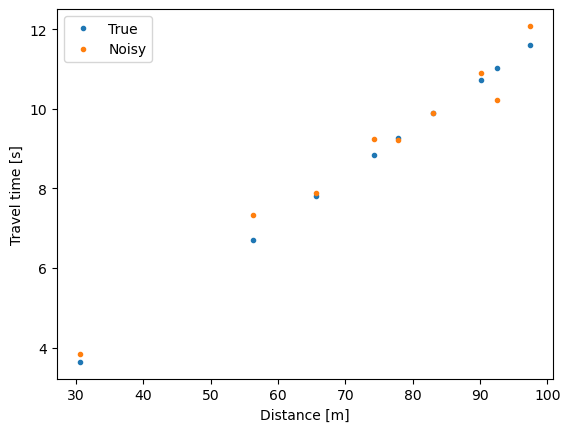

In [85]:
[trace.stats.coordinates for trace in stream]
longitudes = np.array([trace.stats.coordinates.longitude for trace in stream])
latitudes = np.array([trace.stats.coordinates.latitude for trace in stream])
depths = np.array([-1e-3 * trace.stats.coordinates.elevation for trace in stream])

cartesian_coordinates = covseisnet.spatial.geographical_to_cartesian(longitudes, latitudes, depths)
barycenter = np.mean(cartesian_coordinates, axis=1)
cartesian_coordinates -= barycenter[:, None]
# print(cartesian_coordinates)

# Source location
source_location = np.array([23.3465, 39.8812, 10.0])
source_location = covseisnet.spatial.geographical_to_cartesian(*source_location)
source_location -= barycenter

# Compute travel times
vp = 6.0
vs = 3.5

# Compute travel times
distances = np.linalg.norm(cartesian_coordinates - source_location[:, None], axis=0)
tp = distances / vp
ts = distances / vs
tsp = ts - tp 
tsp_noise = tsp + np.random.normal(0, 0.5, len(ts))

# Plot travel times
print(distances)
fig, ax = plt.subplots()
ax.plot(distances, tsp, ".", label="True")
ax.plot(distances, tsp_noise, ".", label="Noisy")
ax.set_xlabel("Distance [m]")
ax.set_ylabel("Travel time [s]")
ax.legend()

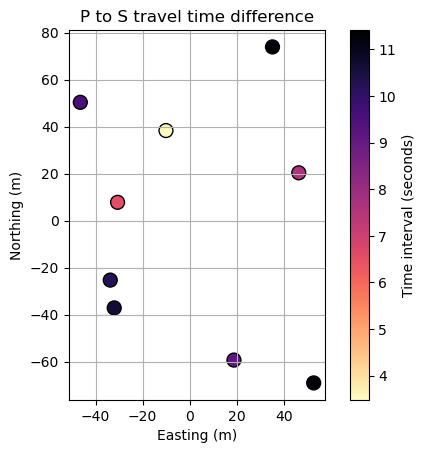

In [65]:
# Read csv
# data = pd.read_csv("./data/travel_times_diff_s_p_3.csv", index_col=0)
data = pd.DataFrame({"x": cartesian_coordinates[0], "y": cartesian_coordinates[1], "tt": tsp_noise})

# Plot
fig, ax = plt.subplots()
mappable = ax.scatter(data.x, data.y, c=data.tt, s=100, edgecolor="k", cmap="magma_r")

# Colorbar
colorbar = fig.colorbar(mappable)
colorbar.set_label("Time interval (seconds)")

# Labels
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("P to S travel time difference")
ax.set_aspect("equal")
ax.grid()

# Show
plt.show()

### 2.2. Mean-squared error source location

The misfit function, denoted $\varepsilon$ in the following, is a very important stage for every inverse problem. This function helps you identifying the best solution of your problem. Depending on the misfit function, you may identify different best solutions. The mean squared error is one of the most used misfit function. If allows to quantify the average diffence between observed and predicted values by delivering the spread of the actual differences (second-order moment). Given an observed set of $N$ quantities $\mathbf{y} = (y_1, \ldots, y_N)$ and corresponding predicted quantities $\hat{\bf y} = (\hat{y}_1, \ldots, \hat{y}_N)$, the mean squared error function $\varepsilon$ defines as

$$\varepsilon = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$$

For most problems, we want to find the set of parameters $\theta$ that minimize the mean square error function. Indeed, the predicted quantities are usually obtained for a given set of parameters, $\hat{\mathbf{y}} = f(\theta)$ (also called model prediction). The problem therefore writes

$$\theta^* = \argmin_{\theta} \frac{1}{N} \| \mathbf{y} - \hat{\mathbf{y}}_\theta \|^2 $$

In [80]:
def model_prediction(x_test, y_test, x_station, y_station, sp_theo=0.05):
    distance = np.sqrt((x_station - x_test) ** 2 + (y_station - y_test) ** 2)
    tt_predicted = distance * sp_theo
    return tt_predicted

def mean_squared_error(tt_predicted, tt_observed):
    squared_error = np.sqrt((tt_predicted - tt_observed) ** 2)
    return np.mean(squared_error)

Once the model prediction and the misfit function are defined, we can search for the best matching source in the grid. This stage is usually the most computationally expensive stage, because we need to make __loops__ and calculate many times the prediction and mean squared error. 

> __Question 2.__ How does the source position evolve with respect to the number of points in the search grid? Does it converges towards a certain position?

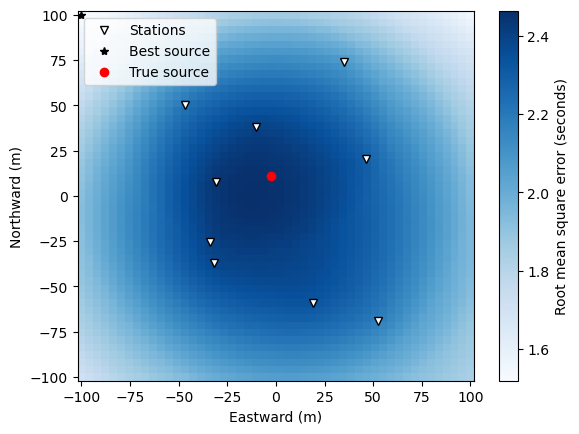

In [81]:
# Grid for searching misfit
x = y = np.linspace(-100, 100, 50)

# Initialize misfit values in the grid
mse = np.zeros((x.shape[0], x.shape[0]))

# Loop over every sources to text, and get misfit
for i in range(len(x)):
    for j in range(len(y)):
        tt_predicted = model_prediction(x[i], y[j], data.x, data.y)
        mse[i, j] = np.sqrt(mean_squared_error(tt_predicted, data.tt))

# Extract best-matching source (from minimum misfit)
mse_min_i, mse_min_j = np.unravel_index(mse.argmin(), mse.shape)
x_best, y_best = x[mse_min_i], y[mse_min_j]

# Plot
fig, ax = plt.subplots()
mappable = ax.pcolormesh(x, y, mse.T, cmap="Blues")
ax.plot(data.x, data.y, "wv", mec="k", label="Stations")
ax.plot(x_best, y_best, "k*", label="Best source")
ax.plot(source_location[0], source_location[1], "ro", label="True source")

# Labels
colorbar = plt.colorbar(mappable, ax=ax)
colorbar.set_label("Root mean square error (seconds)")
ax.set_xlabel("Eastward (m)")
ax.set_ylabel("Northward (m)")
ax.legend()

# Show
plt.show()

### 2.3. Residuals

Ahah, you thought that was it? How do you actually make sure the minimum misfit is a good estimate or a bad one? What can you use to evaluate the results quality? A powerfull tool is the analysis of the residuals. The residuals give you the indivial error at every station. It is simply defined by the element-wise error between the observed and the predicted data

$$r_i = y_i - \hat{y}_i^*$$

where $\hat{y}_i^*$ is the best matching source obtained for $\theta^*$.

> __Question 3.__  How do the residuals behave with different number of grid points? How does the theoretical travel time difference between _S_ and _P_ waves impact this result? Given the outlier analysis provided in the cell below, what would be a good strategy to locate the event better?

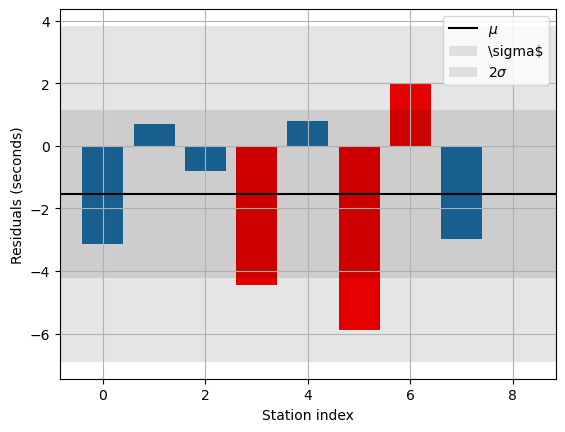

In [82]:
# Get residuals
tt_star = model_prediction(x_best, y_best, data.x, data.y)
residuals = tt_star - data.tt
r_mean = residuals.mean()
r_std = residuals.std()

# Plot
fig, ax = plt.subplots()

# All residuals
ax.bar(data.index, residuals)
for index, residual in enumerate(residuals):
    if (residual > (r_mean + r_std)) | (residual < (r_mean - r_std)):
        ax.bar(index, residual, fc="r")
    if (residual > (r_mean + 2 * r_std)) | (residual < (r_mean - 2 * r_std)):
        ax.bar(index, residual, fc="k")
ax.axhline(r_mean, c="k", label=r"$\mu$")
ax.axhspan(r_mean - r_std, r_mean + r_std, label=r"\sigma$", alpha=0.1, fc="k")
ax.axhspan(r_mean - 2 * r_std, r_mean + 2 * r_std, label=r"$2\sigma$", alpha=0.1, fc="k")
ax.legend()
ax.set_xlabel("Station index")
ax.set_ylabel("Residuals (seconds)")
ax.grid()

# Show
plt.show()

### 2.4. Comparison with different misfit functions

As explained above, several techniques can be used to evaluate the misfit between the predicted travle times and the observed ones. We here use two new functions, named likelihood functions, that define two different approaches. The next cell allows to identify the best matching source from the likelihood functions defined above. 

> __Question 4.__ Check the likelihood functions defined below. What is the main difference between the two functions? Compared with the misfit function, what is the main change we need to do in order to find the best-matching source? How is the likelihood distribution compared with the mean squared error for the same event? From visual inspection, what is the most convenient function to estimate simultaneously the location quality and the best location?

In [83]:
def likelihood_1(tt_predicted, tt_observed, tolerance=4):
    mse = mean_squared_error(tt_predicted, tt_observed)
    return np.exp(-mse / (2 * tolerance ** 2))

def likelihood_2(tt_predicted, tt_observed, tolerance=4):
    se = (tt_predicted - tt_observed) ** 2
    return np.mean(np.exp(-se / (2 * tolerance ** 2)))

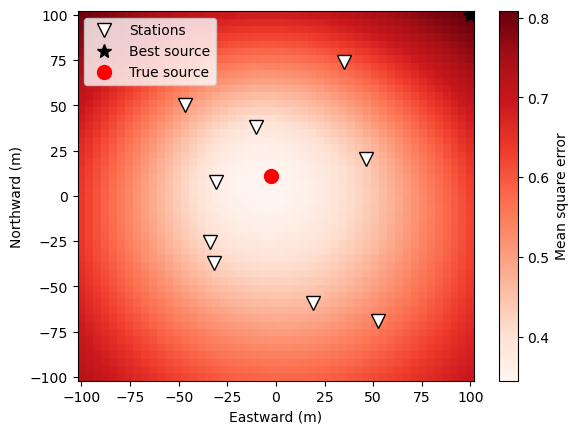

In [84]:
# Initialize misfit values in the grid
mse = np.zeros((x.shape[0], x.shape[0]))

# Loop over every sources to text, and get misfit
for i in range(len(x)):
    for j in range(len(y)):
        tt_predicted = model_prediction(x[i], y[j], data.x, data.y)
        mse[i, j] = likelihood_2(tt_predicted, data.tt)

# Extract best-matching source (from minimum misfit)
mse_min_i, mse_min_j = np.unravel_index(mse.argmax(), mse.shape)
x_best, y_best = x[mse_min_i], y[mse_min_j]

# Plot
fig, ax = plt.subplots()
mappable = ax.pcolormesh(x, y, mse.T, cmap="Reds")
ax.plot(data.x, data.y, "wv", mec="k", ms=10, label="Stations")
ax.plot(x_best, y_best, "k*", ms=10, label="Best source")
ax.plot(source_location[0], source_location[1], "ro", ms=10, label="True source")

# Labels
colorbar = plt.colorbar(mappable, ax=ax)
colorbar.set_label("Mean square error")
ax.set_xlabel("Eastward (m)")
ax.set_ylabel("Northward (m)")
ax.legend()

# Show
plt.show()

> __Question 5.__ From the cells aboves, provide and estimate of the likelihood residuals. Provide comments on the quality of the likelihood compared with the mean squared error approch. What do you get from the other datasets?

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/var/folders/vb/xqq7d5zj58l1hwcqvtq16zf00000gn/T/ipykernel_21472/1661169269.py:17: SyntaxWarning: invalid escape sequence '\m'
  ax.axhline(r_mean, c="k", label="$\mu$")
/var/folders/vb/xqq7d5zj58l1hwcqvtq16zf00000gn/T/ipykernel_21472/1661169269.py:18: SyntaxWarning: invalid escape sequence '\s'
  ax.axhspan(r_mean - r_std, r_mean + r_std, label="$\sigma$", alpha=0.1, fc="k")
/var/folders/vb/xqq7d5zj58l1hwcqvtq16zf00000gn/T/ipykernel_21472/1661169269.py:19: SyntaxWarning: invalid escape sequence '\s'
  ax.axhspan(r_mean - 2 * r_std, r_mean + 2 * r_std, label="$2\sigma$", alpha=0.1, fc="k")


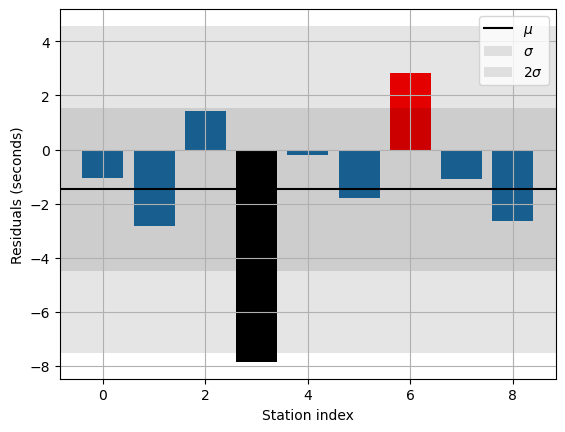

In [85]:
# Get residuals
tt_star = model_prediction(x_best, y_best, data.x, data.y)
residuals = tt_star - data.tt
r_mean = residuals.mean()
r_std = residuals.std()

# Plot
fig, ax = plt.subplots()

# All residuals
ax.bar(data.index, residuals)
for index, residual in enumerate(residuals):
    if (residual > (r_mean + r_std)) | (residual < (r_mean - r_std)):
        ax.bar(index, residual, fc="r")
    if (residual > (r_mean + 2 * r_std)) | (residual < (r_mean - 2 * r_std)):
        ax.bar(index, residual, fc="k")
ax.axhline(r_mean, c="k", label="$\mu$")
ax.axhspan(r_mean - r_std, r_mean + r_std, label="$\sigma$", alpha=0.1, fc="k")
ax.axhspan(r_mean - 2 * r_std, r_mean + 2 * r_std, label="$2\sigma$", alpha=0.1, fc="k")
ax.legend()

# Labels
ax.set_xlabel("Station index")
ax.set_ylabel("Residuals (seconds)")
ax.grid()

# Show
plt.show()

## 3. Real dataset

### 3.1. Read data

Using your expertise, and the knowledge your acquired during the first and second notebook session, download (using the script `download_earthquakes.py`) and read the seismograms under the `data/` folder. These seismograms correspond to 15 earthquakes located around Greece, between Italy and Turkey. 

### 3.2. Pick _P_ and _S_ arrival times

Using your newly acquired expertise as seismologist, identify the _P_ and _S_ wave arrivals visually (or automatically) on the waveform of each stations for an earthquake of your choice. Then report the arrival times in a csv file.

Note that the automatic picking of phases can be done with ObsPy, without a garanteed quality. If you are curious, you can have a look at the [ObsPy's Trigger/Picker Tutorial](https://docs.obspy.org/tutorial/code_snippets/trigger_tutorial.html).

### 3.3. Infer the earthquake epicenter

Assuming a distance law for $\tau_{SP}$, use the infered $\tau_{SP}$ to estimate the location of the 15 earthquakes. By comparing your obtained location with the trusted locations indicated by USGS (check the catalog file), discuss your obtained locations depending on the used stations, and propagation assumptions.
